In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#what are columns in these tables?
# Query All Records in the the Database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


##  Precipitation Analysis 

- #### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
from dateutil.relativedelta import relativedelta

In [13]:
# Calculate the date 1 year ago from the last data point in the database
date = session.query(func.max(Measurement.date)).all()
newest_date = date[0][0] 
newest_date = datetime.strptime(newest_date, '%Y-%m-%d')
end_date = newest_date - relativedelta(months=12)
print(end_date)

2016-08-23 00:00:00


In [14]:
type(newest_date)

datetime.datetime

- #### Select only the date and prcp values 

In [15]:
# Perform a query to retrieve the data and precipitation scores the last 12 months
months_of_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > end_date).all()

- #### Load the query results into a Pandas DataFrame and set the index to the date column 

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
months_of_precip_df = pd.DataFrame(months_of_precip)

months_of_precip_df.set_index('date', inplace=True)
months_of_precip_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


- #### Sort the DataFrame values by date 

In [17]:
# Sort the dataframe by date
months_of_precip_df.sort_index(inplace=True)

- #### Plot the results using the DataFrame plot method. 

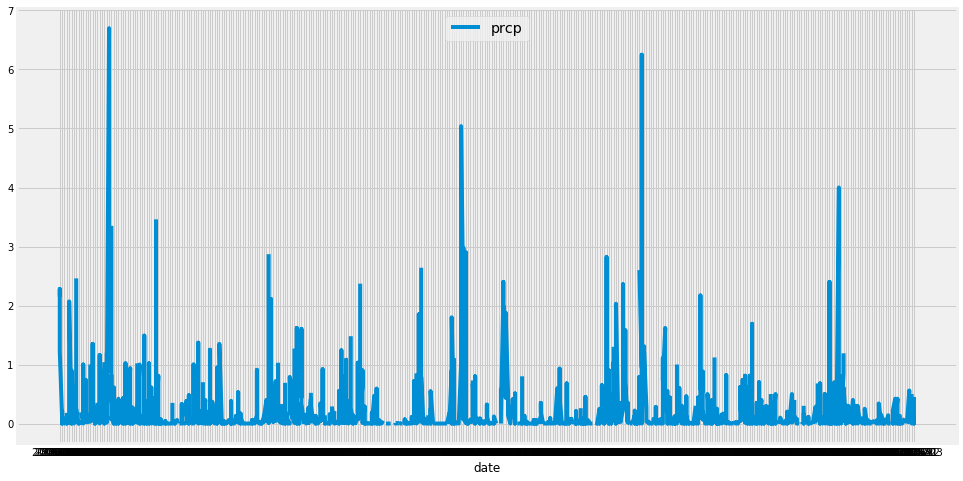

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
#figure needs to be place before the plotting the graph
plt.figure(figsize=(15,8))
plt.plot(months_of_precip_df.index.values, months_of_precip_df['prcp'])
plt.legend(loc='upper center', fontsize='x-large')
plt.xlabel("date")
plt.show()

- #### Plot the results using the DataFrame plot method 

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
months_of_precip_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [20]:
#what are the columns names in this table?
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


- #### Design a query to show how many stations are available in this dataset?

In [21]:
# Print all of the station names in the database
station_names = session.query(Station).all()
for station_name in station_names:
  print(station_name.id, station_name.station)

1 USC00519397
2 USC00513117
3 USC00514830
4 USC00517948
5 USC00518838
6 USC00519523
7 USC00519281
8 USC00511918
9 USC00516128


In [22]:
stations_available = session.query(Station).\
    filter(Station.id).count()
print("There are {} stations available in this dataset".format(stations_available))


There are 9 stations available in this dataset


- #### Design a query to find the most active stations. 

>  *  List the stations and observation counts in descending order. 

In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?

# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station).\
                                         label("Frequented")).group_by(Measurement.station).order_by('Frequented DESC').all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

>  *  Which station has the highest number of observations? 

In [24]:
most_active_station = station_activity[0][0]

print(f'The station with the highest number of observations is {most_active_station}')


The station with the highest number of observations is USC00519281


>  -  Using the station id from the previous query, calculate the __lowest__ temperature recorded, __highest__ temperature recorded, and __average__ temperature of the  <font color=blue> _most active station_ </font>


In [25]:
#Get the row with the lowest temperature

lowestTemp_mostActivity = session.query(Measurement.station, func.min(Measurement.tobs)).\
                                    filter(Measurement.station == 'USC00519281').all()
#Get the highest precipitation from the list
lowest_temperature_recorded = lowestTemp_mostActivity[0][1]

#print the highest temperature
print(f'lowest temperature recorded from the station with the most activity is {lowest_temperature_recorded}')

lowest temperature recorded from the station with the most activity is 54.0


In [26]:
#Get the row with the highest temperature

highestTemp_mostActivity = session.query(Measurement.station, func.max(Measurement.tobs)).\
                                    filter(Measurement.station == 'USC00519281').all()
#Get the highest precipitation from the list
highest_temperature_recorded = highestTemp_mostActivity[0][1]

#print the highest temperature
print(f'highest temperature recorded from the station with the most activity is {highest_temperature_recorded}')

highest temperature recorded from the station with the most activity is 85.0


In [27]:
#Get the average temperature

averageTemp_mostActivity = session.query(Measurement.station, func.avg(Measurement.tobs)).\
                                    filter(Measurement.station == 'USC00519281').all()
#Get the average precipitation from the list
average_temperature_recorded = round(averageTemp_mostActivity[0][1], 2)

#print the average temperature
print(f'average temperature recorded from the station with the most activity is {average_temperature_recorded}')

average temperature recorded from the station with the most activity is 71.66


- #### Design a query to retrieve the last 12 months of temperature observation data (tobs) 
> - Filter by the station with the highest number of observations.

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_observations = session.query(Measurement.tobs)\
                                       .filter( Measurement.date >= end_date)\
                                       .filter(Measurement.station == 'USC00519281').all()


In [29]:
# Save the query results as a Pandas DataFrame and set the index to the date column
highest_observations_df = pd.DataFrame(highest_observations, columns=['tobs'])


> - Plot the results as a histogram with bins=12

<Figure size 288x288 with 0 Axes>

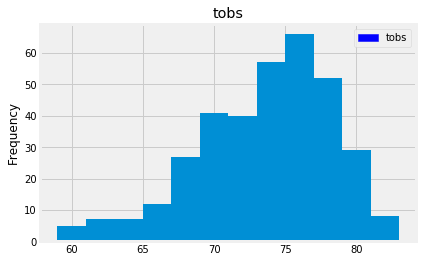

In [30]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.patches as mpatches

my_dpi=800

plt.figure(figsize=(2, 2), dpi=144)

highest_observations_df[highest_observations_df['tobs'] >= 0].hist(bins=12)

red_patch = mpatches.Patch(color='blue', label='tobs')
plt.legend(handles=[red_patch])
plt.ylabel("Frequency")
plt.show()


# Temperature Analysis <font color=blue> (Optional) </font>

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [34]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## <font color=blue>Optional </font> Challenge Assignment

In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [38]:
# Plot the daily normals as an area plot with `stacked=False`
